In [1]:
import sys
sys.path.append('/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/')
import numpy as np
import random
import torch
from gpytorch.kernels import ScaleKernel, RBFKernel
from linear_operator.operators import KroneckerProductLinearOperator
from torch import Tensor
from torch.distributions import MultivariateNormal
from models_.lvmogp_svi import LVMOGP_SVI
from models_.gaussian_likelihood import GaussianLikelihood
from models_.variational_elbo import VariationalELBO
from tqdm import trange
from torch.optim.lr_scheduler import StepLR
from util_functions import *

## Experi random seed

In [2]:
expri_random_seed = 13

## Load in data

In [3]:
# This section is same as 'no missing data' case.
w_n_C_total = 100 # totally 700 points for C
w_n_outputs = 30 # 300
w_X_true, w_C_total, w_sample_total_data, kernel_parameters = tidily_sythetic_data_from_MOGP(n_C=w_n_C_total, n_X=w_n_outputs)

w_n_C_train = 20 # the number of training data points per output
w_n_C_test = w_n_C_total - w_n_C_train

np.random.seed(expri_random_seed)
list_expri_random_seeds = np.random.randn(w_n_outputs)

# different from the previous case, C_train and C_test no longer a single set, but every output has different values.
w_ls_of_ls_train_C = []
w_ls_of_ls_test_C = []

w_sample_train_index, w_sample_test_index = [], []

for i in range(w_n_outputs):
    # iterate across different output functions
    random.seed(list_expri_random_seeds[i])
    train_index = random.sample(range(w_n_C_total), w_n_C_train)
    test_index = [index for index in range(w_n_C_total) if index not in train_index]
    w_ls_of_ls_train_C.append(train_index)
    w_ls_of_ls_test_C.append(test_index)

    w_sample_train_index = np.concatenate((w_sample_train_index, list(np.array(train_index) + w_n_C_total*i)))
    w_sample_test_index = np.concatenate((w_sample_test_index, list(np.array(test_index) + w_n_C_total*i)))

w_sample_train_data = w_sample_total_data[w_sample_train_index]
w_sample_test_data = w_sample_total_data[w_sample_test_index]

assert w_sample_train_data.shape[0] == w_n_C_train * w_n_outputs
assert w_sample_test_data.shape[0] == w_n_C_test * w_n_outputs


Dataset Generated!


## Define model and Training

In [14]:
'''
# define hyper-parameters
w_n_X = w_X_true.shape[0]
w_n_C = len(w_ls_of_ls_train_C[0])
w_n_total = w_n_X * w_n_C
w_index_dim = 1
w_latent_dim = 2
w_n_inducing_C = 10
w_n_inducing_X = 50
w_pca = False

Y_train = w_sample_train_data

# specify model
w_my_model = LVMOGP_SVI(w_n_X, w_n_C, w_index_dim, w_latent_dim, w_n_inducing_C, w_n_inducing_X, Y_train.reshape(w_n_X, -1), pca=w_pca)

# Likelihood & training objective
w_likelihood = GaussianLikelihood()
w_mll = VariationalELBO(w_likelihood, w_my_model, num_data=w_n_total)

# optimizer and scheduler
w_optimizer = torch.optim.Adam([
    {'params': w_my_model.parameters()},
    {'params': w_likelihood.parameters()} 
], lr=0.5)

w_scheduler = StepLR(w_optimizer, step_size=50, gamma=0.95)  # every 50 iterations，learning rate multiple 0.95

# Initialize inducing points in C space
w_my_model.variational_strategy.inducing_points_C.data = torch.rand(w_n_inducing_C).reshape(-1,1) * 20 - 10

# start training!
w_loss_list = []
n_iterations = 1500 # 10000
iterator = trange(n_iterations, leave=True)
batch_size_X = 10
batch_size_C = 15 # one can set w_n_C_train
w_model_max_grad_norm = 10
w_likeli_max_grad_norm = 0.7

w_my_model.train()
w_likelihood.train()
for i in iterator: 
    batch_index_X, batch_index_C = sample_index_X_and_C_from_list(w_ls_of_ls_train_C, batch_size_X=batch_size_X, batch_size_C=batch_size_C)
    # core code is here 
    w_optimizer.zero_grad()
    sample_batch_X = w_my_model.sample_latent_variable(batch_index_X)
    sample_batch_C = w_C_total[batch_index_C]
    output_batch = w_my_model(sample_batch_X, sample_batch_C) # q(f)
    batch_index_Y = inhomogeneous_index_of_batch_Y(batch_index_X, batch_index_C, w_n_X, w_n_C_total)
    # print('batch_index_Y', len(batch_index_Y))
    loss = -w_mll(output_batch, w_sample_total_data[batch_index_Y]).sum()
    w_loss_list.append(loss.item())
    iterator.set_description('Loss: ' + str(float(np.round(loss.item(),3))) + ", iter no: " + str(i))
    loss.backward()

    # Clip gradients
    torch.nn.utils.clip_grad_norm_(w_my_model.parameters(), w_model_max_grad_norm)
    torch.nn.utils.clip_grad_norm_(w_likelihood.parameters(), w_likeli_max_grad_norm)

    w_optimizer.step()
    w_scheduler.step()
'''

Loss: 1.2, iter no: 1499: 100%|██████████| 1500/1500 [06:23<00:00,  3.91it/s]  


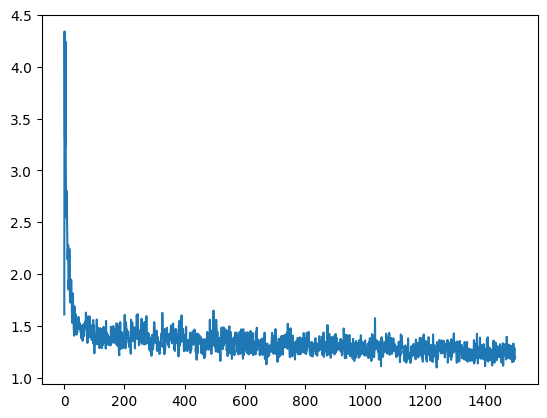

In [15]:
import matplotlib.pyplot as plt

plt.plot(w_loss_list)

## Testing

In [24]:
'''
# prediction output for grid (total) inputs.
w_my_model.eval()
w_likelihood.eval()

batch_size_X = w_n_outputs
batch_size_C = w_n_C_total # this number must equal to n_total
sample_X = w_my_model.X.q_mu # TODO: try other meaningful approaches, such as monte carlo samling approximation ...

batch_index_X = np.array([[i]*batch_size_C for i in range(batch_size_X)]).reshape(-1).tolist() 
batch_index_C = [i for i in range(batch_size_C)] * batch_size_X 

assert len(batch_index_X) == len(batch_index_C)

sample_batch_X = sample_X[batch_index_X]
sample_batch_C = w_C_total[batch_index_C]
w_grid_output_batch = w_my_model(sample_batch_X, sample_batch_C) # q(f)
# passing through likelihood
w_grid_output_batch = w_likelihood(w_grid_output_batch)

w_train_data_predict = w_grid_output_batch.loc.detach()[w_sample_train_index]
train_rmse = (w_train_data_predict - w_sample_train_data).square().mean().sqrt()
print('Global Train RMSE', train_rmse)

w_test_data_predict = w_grid_output_batch.loc.detach()[w_sample_test_index]
test_rmse = (w_test_data_predict - w_sample_test_data).square().mean().sqrt()
print('Global Test RMSE', test_rmse)
'''


Global Train RMSE tensor(0.6364)
Global Test RMSE tensor(0.7371)


In [17]:
# prediction output for grid (total) inputs.
w_my_model.eval()
w_likelihood.eval()

all_index_X = np.array([[i]*w_n_C_total for i in range(w_n_outputs)]).reshape(-1).tolist() 
all_index_C = [i for i in range(w_n_C_total)] * w_n_outputs 
len_X = len(all_index_X)
assert len_X == len(all_index_C)
all_mean_X = w_my_model.X.q_mu

test_mini_batch_size = 1000

all_pred_mean = torch.zeros(len_X)
all_pred_var = torch.zeros(len_X)
test_continue = True
test_start_idx = 0
test_end_idx = test_mini_batch_size

while test_continue:
    batch_X = all_mean_X[all_index_X[test_start_idx:test_end_idx]]
    batch_C = w_C_total[all_index_C[test_start_idx:test_end_idx]]
    batch_output = w_likelihood(w_my_model(batch_X, batch_C))
    all_pred_mean[test_start_idx:test_end_idx] = batch_output.loc.detach()
    all_pred_var[test_start_idx:test_end_idx] = batch_output.variance.detach()

    if test_end_idx < len_X:
        test_start_idx += test_mini_batch_size
        test_end_idx += test_mini_batch_size
        test_end_idx = min(test_end_idx, len_X)
    else:
        test_continue = False

## Train/Test data RMSE

In [18]:
w_train_data_predict = all_pred_mean[w_sample_train_index]
train_rmse = (w_train_data_predict - w_sample_train_data).square().mean().sqrt()
print('Global Train RMSE', train_rmse)

w_test_data_predict = all_pred_mean[w_sample_test_index]
test_rmse = (w_test_data_predict - w_sample_test_data).square().mean().sqrt()
print('Global Test RMSE', test_rmse)

Global Train RMSE tensor(0.6364)
Global Test RMSE tensor(0.7371)


## Visual Inspect

In [22]:
# Pick the index of the funtion to show
w_function_index = 20 # 0 - 19 (in total 20 output functions)

w_train_input = w_C_total[w_ls_of_ls_train_C[w_function_index]]
w_train_start = 0
for i in range(w_function_index):
    w_train_start += len(w_ls_of_ls_train_C[i]) # don't assume every output has the same length of inputs
w_train_end = w_train_start + len(w_ls_of_ls_train_C[w_function_index])
w_train_target = w_sample_train_data[w_train_start:w_train_end]
w_train_predict = w_train_data_predict[w_train_start:w_train_end]
train_rmse = (w_train_target - w_train_predict).square().mean().sqrt()
print('train rmse', train_rmse)

w_test_input = w_C_total[w_ls_of_ls_test_C[w_function_index]]
w_test_start = 0
for j in range(w_function_index):
    w_test_start += len(w_ls_of_ls_test_C[i])
w_test_end = w_test_start + len(w_ls_of_ls_test_C[w_function_index])
w_test_target = w_sample_test_data[w_test_start:w_test_end]
w_test_predict = w_test_data_predict[w_test_start:w_test_end]
test_rmse = (w_test_predict - w_test_target).square().mean().sqrt()
print('test rmse', test_rmse)

w_gp_input = w_C_total
w_gp_start = w_gp_input.shape[0] * w_function_index
w_gp_end = w_gp_start + w_gp_input.shape[0]
w_gp_target = w_sample_total_data[w_gp_start:w_gp_end]

w_gp_pred_mean = all_pred_var[w_gp_start:w_gp_end]
w_gp_pred_std = all_pred_var[w_gp_start:w_gp_end]

train rmse tensor(0.4058)
test rmse tensor(0.5898)


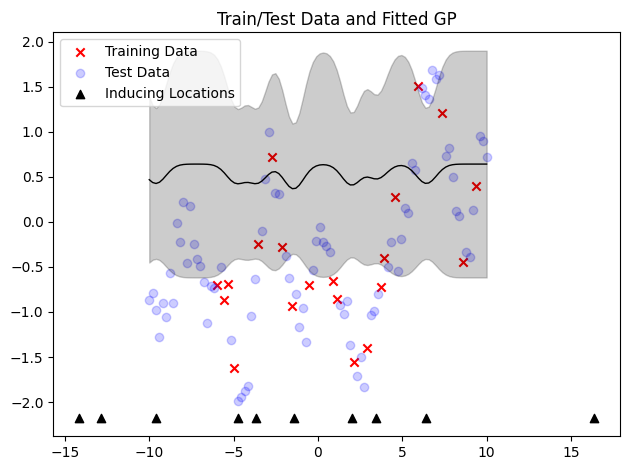

In [23]:
plot_traindata_testdata_fittedgp(train_X=w_train_input, train_Y=w_train_target, test_X=w_test_input, test_Y=w_test_target, gp_X=w_gp_input, gp_pred_mean=w_gp_pred_mean, gp_pred_std=w_gp_pred_std, inducing_points_X=w_my_model.variational_strategy.inducing_points_C.data, n_inducing_C=w_n_inducing_C) # NOTE: input is C not X

## True v.s. Fitted latent variables

In [21]:
# plot_true_and_fitted_latent(w_X_true, w_my_model.X.q_mu.detach(), torch.nn.functional.softplus(w_my_model.X.q_log_sigma.detach()))